# Libraries and data importing

Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing data

In [2]:
activities = pd.read_parquet('../data-raw/activities.parquet')
activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,analysis-bot,bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,neos-bot,bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


Calculating the date 3 months ago from the last date in the data and filters the dataframe to include only the rows with dates greater than or equal to the date 3 months ago

In [3]:
thresholded_activities = (
    activities[activities['date'] >= activities['date'].max() - pd.DateOffset(months=3)]
    .groupby(['category', 'contributor'])
    .tail(300)
    .reset_index(drop=True)
)
thresholded_activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2023-01-15 16:15:53+00:00
1,stickler-ci[bot],bot,Humml87/dolibarr,Pushing commits,2023-01-15 17:31:52+00:00
2,apollo-cla,bot,apollographql/apollo-rs,Commenting pull request,2023-01-15 17:42:50+00:00
3,dune-community-bot,bot,dune-mirrors/dune-fem,Creating branch,2023-01-15 18:00:14+00:00
4,AmplabJenkins,bot,apache/spark,Commenting pull request,2023-01-15 18:20:48+00:00
...,...,...,...,...,...
140748,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
140749,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
140750,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
140751,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


In [4]:
data = (
    thresholded_activities
    .assign(
        time_difference=(
            thresholded_activities
            .groupby(['contributor', 'category'])['date']
            .diff()
            .dt.total_seconds()
            .dropna()
        )
    )
    .dropna()
    [['category', 'date', 'contributor', 'time_difference']]
)
data['time_difference'] = data['time_difference'].astype('int')
data

,category,date,contributor,time_difference
4,bot,2023-01-15 18:20:48+00:00,AmplabJenkins,7495
5,bot,2023-01-15 18:20:51+00:00,AmplabJenkins,3
8,bot,2023-01-15 19:07:28+00:00,pr-benchmarks[bot],9
10,bot,2023-01-15 19:09:58+00:00,poggit-bot,1
12,bot,2023-01-15 20:00:12+00:00,dune-community-bot,7198
...,...,...,...,...
140748,human,2023-04-15 16:06:15+00:00,798388,41
140749,human,2023-04-15 16:07:26+00:00,798388,71
140750,human,2023-04-15 16:07:33+00:00,784775,85
140751,human,2023-04-15 16:08:07+00:00,784775,34


In [39]:
temp = data[data['contributor'] == '597849']
temp[['date', 'time_difference']]

,date,time_difference
89483,2023-03-06 11:49:47+00:00,14163
89813,2023-03-06 16:23:47+00:00,16440
89915,2023-03-06 18:41:47+00:00,8280
89919,2023-03-06 18:45:08+00:00,201
90079,2023-03-06 20:47:48+00:00,7360
...,...,...
133928,2023-04-12 11:53:00+00:00,1
134937,2023-04-12 20:33:52+00:00,31252
134938,2023-04-12 20:33:57+00:00,5
137224,2023-04-13 21:55:54+00:00,91317


In [38]:
data.sample()

,category,date,contributor,time_difference
127031,human,2023-04-07 14:30:18+00:00,597849,180


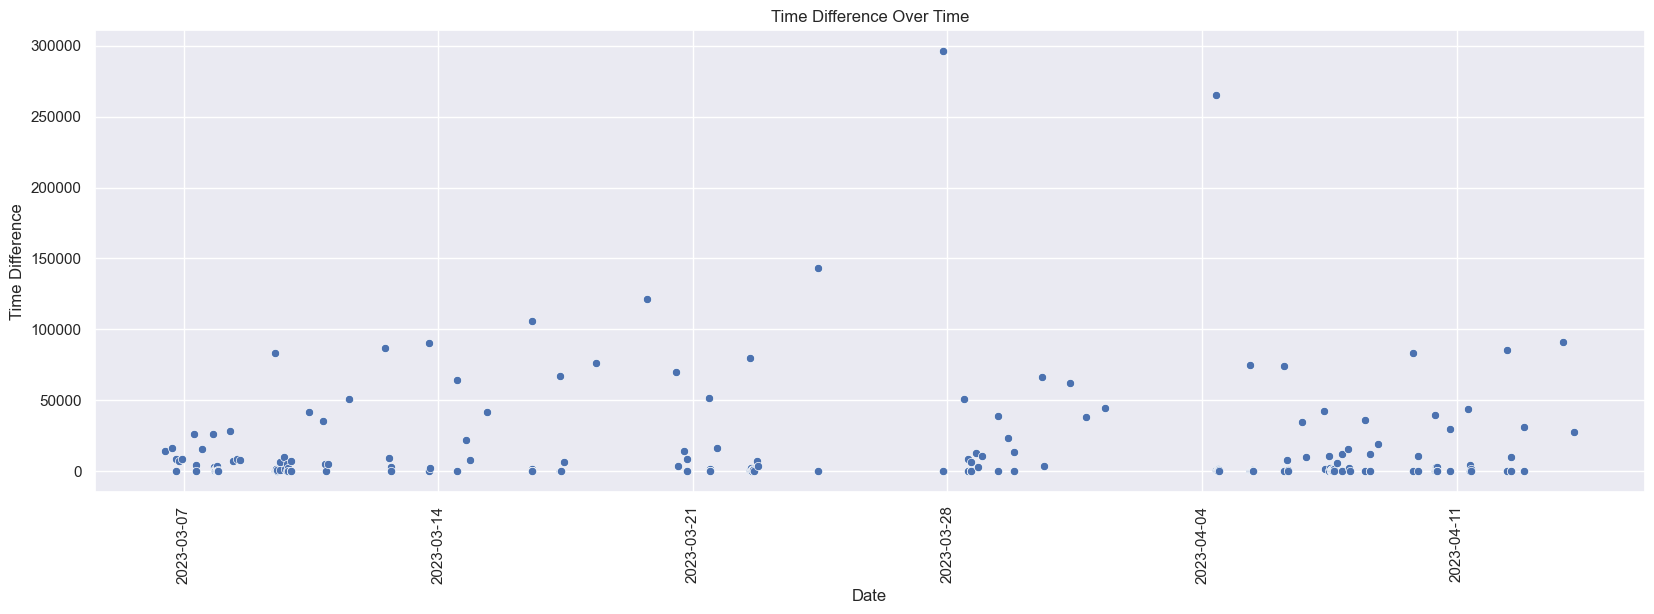

In [40]:
import matplotlib.dates as mdates

# Create a line plot of time_difference over time
ax = sns.scatterplot(x='date', y='time_difference', data=temp)

# Set the figure size
sns.set(rc={'figure.figsize':(20,6)})

# Set the x-axis to weekly intervals
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the x-axis tick labels vertically
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Time Difference')
plt.title('Time Difference Over Time')

# Show the plot
plt.show()

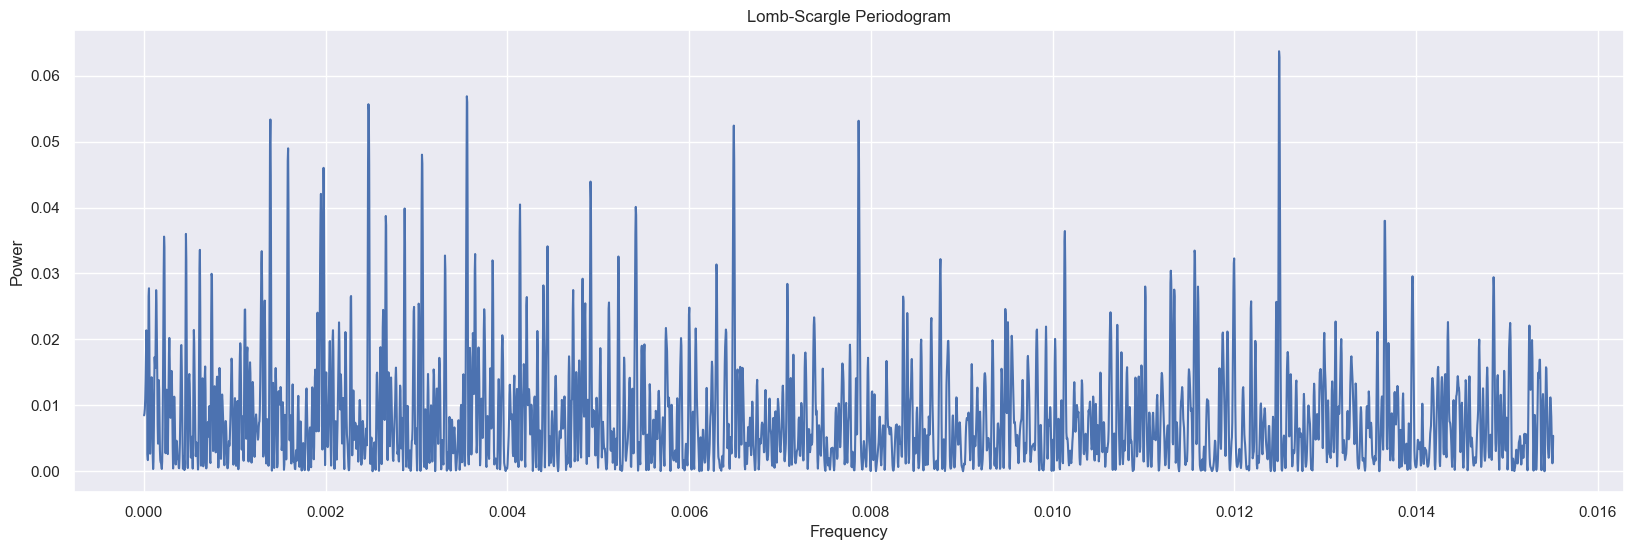

In [41]:
from astropy.timeseries import LombScargle

# Compute the Lomb-Scargle periodogram
frequency, power = LombScargle(temp.index, temp['time_difference']).autopower()

# Plot the result
plt.plot(frequency, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.show()


# blabla

In [56]:
activities[activities['contributor'] == 'pytorchbot']['activity'].value_counts()

activity
Pushing commits            2103
Commenting pull request     111
Reviewing code               57
Opening pull request          6
Closing pull request          2
Name: count, dtype: int64